In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import mlflow

warnings.simplefilter(action='ignore', category=FutureWarning)

# Credit score function

Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix
Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy

In [73]:
# Optimisation du seuil
def find_optimal_threshold(y_true, y_prob, cost_FN, cost_FP):
    thresholds = np.linspace(0, 1, 100)
    costs = []

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        FN = np.sum((y_true == 1) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        cost = cost_FN * np.mean(y_prob[y_true == 1]) * FN + cost_FP * np.mean(y_prob[y_true == 0]) * FP
        costs.append(cost)

    optimal_threshold = thresholds[np.argmin(costs)]
    return optimal_threshold

# Utilisation des fonctions
y_true = np.array([0, 1, 0, 0, 1, 1, 0, 1])
y_prob = np.array([0.2, 0.8, 0.3, 0.1, 0.9, 0.7, 0.4, 0.6])
cost_FN = 1  # Coût des faux négatifs
cost_FP = 2  # Coût des faux positifs

optimal_threshold = find_optimal_threshold(y_true, y_prob, cost_FN, cost_FP)
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Calcul du coût métier avec le seuil optimal*
cost = custom_cost_function(y_true, y_prob, cost_FN, cost_FP)

print(f"Seuil optimal : {optimal_threshold}")
print(f"Prédictions avec seuil optimal : {y_pred_optimal}")
print(f"Coût métier : {cost}")

NameError: name 'custom_cost_function' is not defined

In [74]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [75]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [77]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../ressources/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../ressources/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [78]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../ressources/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [76]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../ressources/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../ressources/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    #df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df],
              ignore_index = True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [79]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../ressources/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [80]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../ressources/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [81]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../ressources/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [82]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [83]:
def credit_cost_function(y_true, y_prob, threshold):
    cost_fp = 100
    cost_fn = 1000

    fn = ((y_true == 1) & (y_prob < threshold)).sum()
    fp = ((y_true == 0) & (y_prob >= threshold)).sum()

    total_cost = (cost_fp * fp) + (cost_fn * fn)
    return total_cost

In [84]:
from sklearn.metrics import mean_squared_error
def credit_cost_function_search_best_threshold(y_true, y_prob):

    best_threshold = 0.5
    best_cost = float('inf')

    for threshold in np.arange(0.05, 1.0, 0.05):  # Parcourir les seuils de 0.1 à 1.0
        cost = credit_cost_function(y_true, y_prob, threshold)
        if cost < best_cost:
            best_threshold = threshold
            best_cost = cost
            print(f'Best cost : {best_cost}')
            print(f'Best Threshold : {best_threshold}')

    # Utiliser le meilleur seuil pour calculer la métrique sur les données de validation
    total_cost = credit_cost_function(y_true, y_prob, best_threshold)
    print(f'Custom Credit Score: {total_cost}')


    return "credit_cost_function", total_cost, None

In [85]:
from sklearn.metrics import mean_squared_error
def credit_cost_function_search_best_threshold_v2(y_true, y_prob):

    best_threshold = 0.5
    best_cost = float('inf')

    for threshold in np.arange(0.05, 1.0, 0.05):  # Parcourir les seuils de 0.1 à 1.0
        cost = credit_cost_function(y_true, y_prob, threshold)
        if cost < best_cost:
            best_threshold = threshold
            best_cost = cost
            print(f'Best cost : {best_cost}')
            print(f'Best Threshold : {best_threshold}')

    # Utiliser le meilleur seuil pour calculer la métrique sur les données de validation
    total_cost = credit_cost_function(y_true, y_prob, best_threshold)
    print(f'Custom Credit Score: {total_cost}')


    return total_cost

In [86]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

In [105]:
num_rows = None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

df.to_csv('../ressources/processed_data.csv', index=False)


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 30s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 32s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s


In [106]:
import re

# Fonction de transformation pour supprimer les caractères spéciaux et mettre en majuscules
def clean_column_name(col_name):
    # Utiliser une expression régulière pour supprimer les caractères spéciaux
    cleaned_name = re.sub(r'\W+', '', col_name)
    # Mettre le nom en majuscules
    cleaned_name_uppercase = cleaned_name.upper()
    return cleaned_name_uppercase

# Renommer les colonnes avec la fonction de transformation
df.rename(columns=clean_column_name, inplace=True)

In [107]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
count,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,3.559730e+05,...,103558.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,103558.0,103558.0,102866.0,103558.000000
mean,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,5.280212e+05,...,0.047597,0.003583,0.106781,0.002955,0.0,0.0,0.0,0.0,0.0,37.083683
std,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,3.660657e+05,...,0.212912,0.031014,1.272522,0.019938,0.0,0.0,0.0,0.0,0.0,33.483627
min,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,75.000000
max,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,1.000000,62.000000,0.500000,0.0,0.0,0.0,0.0,0.0,192.000000


In [108]:
df.isna().sum()

SK_ID_CURR                               0
TARGET                               48744
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                     ...  
CC_NAME_CONTRACT_STATUS_NAN_MAX     252693
CC_NAME_CONTRACT_STATUS_NAN_MEAN    252693
CC_NAME_CONTRACT_STATUS_NAN_SUM     252693
CC_NAME_CONTRACT_STATUS_NAN_VAR     253385
CC_COUNT                            252693
Length: 797, dtype: int64

In [109]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['CC_NAME_CONTRACT_STATUS_ACTIVE_MIN', 'CC_NAME_CONTRACT_STATUS_ACTIVE_MAX', 'CC_NAME_CONTRACT_STATUS_COMPLETED_MIN', 'CC_NAME_CONTRACT_STATUS_COMPLETED_MAX', 'CC_NAME_CONTRACT_STATUS_DEMAND_MIN', 'CC_NAME_CONTRACT_STATUS_DEMAND_MAX', 'CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MIN', 'CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MAX', 'CC_NAME_CONTRACT_STATUS_SIGNED_MIN', 'CC_NAME_CONTRACT_STATUS_SIGNED_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MIN', 'CC_NAME_CONTRACT_STATUS_NAN_MAX']

# Utilisez la méthode drop pour supprimer les colonnes
df = df.drop(columns=colonnes_a_supprimer)

In [111]:
df.to_csv('../ressources/processed_data.csv', index=False)

In [112]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].notnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#del df
gc.collect()



Starting LightGBM. Train shape: (10000, 755), test shape: (10000, 755)


0

In [94]:
train_df.isna().sum()

SK_ID_CURR                               0
TARGET                                   0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                      ... 
CC_NAME_CONTRACT_STATUS_SIGNED_VAR    9991
CC_NAME_CONTRACT_STATUS_NAN_MEAN      9768
CC_NAME_CONTRACT_STATUS_NAN_SUM       9768
CC_NAME_CONTRACT_STATUS_NAN_VAR       9991
CC_COUNT                              9768
Length: 755, dtype: int64

In [95]:
test_df.isna().sum()

SK_ID_CURR                               0
TARGET                                   0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                      ... 
CC_NAME_CONTRACT_STATUS_SIGNED_VAR    9991
CC_NAME_CONTRACT_STATUS_NAN_MEAN      9768
CC_NAME_CONTRACT_STATUS_NAN_SUM       9768
CC_NAME_CONTRACT_STATUS_NAN_VAR       9991
CC_COUNT                              9768
Length: 755, dtype: int64

In [96]:
train_df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,111629,0.0,1,1,0,1,135000.0,270000.0,13500.0,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,111630,0.0,1,1,0,0,166500.0,1006920.0,51543.0,900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,111631,0.0,0,1,0,0,225000.0,497520.0,53581.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,111632,0.0,1,0,1,0,360000.0,348264.0,27643.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
test_df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,111629,0.0,1,1,0,1,135000.0,270000.0,13500.0,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,111630,0.0,1,1,0,0,166500.0,1006920.0,51543.0,900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,111631,0.0,0,1,0,0,225000.0,497520.0,53581.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,111632,0.0,1,0,1,0,360000.0,348264.0,27643.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
num_folds= 10
stratified= False

In [99]:
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


In [100]:
feature_importance_df

""


In [101]:
feats

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APA

# LGBMClassifier

(9000,) (1000,)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost : 90900
Best Threshold : 0.05
Custom Credit Score: 90900
Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost : 90900
Best Threshold : 0.05
Custom Credit Score: 90900
Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost : 90900
Best Threshold : 0.05
Custom Credit Score: 90900
Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost : 90900
Best Threshold : 0.05
Custom Credit Score: 90900
Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost : 90900
Best Threshold : 0.05
Custom Credit Score: 90900
Best cost : 831600
Best Threshold : 0.05
Best cost : 684000
Best Threshold : 0.1
Custom Credit Score: 684000
Best cost :

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 831100
Best Threshold : 0.05
Best cost : 689000
Best Threshold : 0.1
Custom Credit Score: 689000
Best cost : 91400
Best Threshold : 0.05
Best cost : 86000
Best Threshold : 0.1
Custom Credit Score: 86000
Best cost : 831100
Best Threshold : 0.05
Best cost : 689000
Best Threshold : 0.1
Custom Credit Score: 689000
Best cost : 91400
Best Threshold : 0.05
Best cost : 86000
Best Threshold : 0.1
Custom Credit Score: 86000
Best cost : 831100
Best Threshold : 0.05
Best cost : 689000
Best Threshold : 0.1
Custom Credit Score: 689000
Best cost : 91400
Best Threshold : 0.05
Best cost : 86000
Best Threshold : 0.1
Custom Credit Score: 86000
Best cost : 831100
Best Threshold : 0.05
Best cost : 689000
Best Threshold : 0.1
Custom Credit Score: 689000
Best cost : 91400
Best Threshold : 0.05
Best cost : 86000
Best Threshold : 0.1
Custom Credit Score: 86000
Best cost : 831100
Best Threshold : 0.05
Best cost : 689000
Best Threshold : 0.1
Custom Credit Score: 689000
Best cost : 91400
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 831000
Best Threshold : 0.05
Best cost : 690000
Best Threshold : 0.1
Custom Credit Score: 690000
Best cost : 91500
Best Threshold : 0.05
Best cost : 85000
Best Threshold : 0.1
Custom Credit Score: 85000
Best cost : 831000
Best Threshold : 0.05
Best cost : 690000
Best Threshold : 0.1
Custom Credit Score: 690000
Best cost : 91500
Best Threshold : 0.05
Best cost : 85000
Best Threshold : 0.1
Custom Credit Score: 85000
Best cost : 831000
Best Threshold : 0.05
Best cost : 690000
Best Threshold : 0.1
Custom Credit Score: 690000
Best cost : 91500
Best Threshold : 0.05
Best cost : 85000
Best Threshold : 0.1
Custom Credit Score: 85000
Best cost : 831000
Best Threshold : 0.05
Best cost : 690000
Best Threshold : 0.1
Custom Credit Score: 690000
Best cost : 91500
Best Threshold : 0.05
Best cost : 85000
Best Threshold : 0.1
Custom Credit Score: 85000
Best cost : 831000
Best Threshold : 0.05
Best cost : 690000
Best Threshold : 0.1
Custom Credit Score: 690000
Best cost : 91500
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 830400
Best Threshold : 0.05
Best cost : 696000
Best Threshold : 0.1
Custom Credit Score: 696000
Best cost : 92100
Best Threshold : 0.05
Best cost : 79000
Best Threshold : 0.1
Custom Credit Score: 79000
Best cost : 830400
Best Threshold : 0.05
Best cost : 696000
Best Threshold : 0.1
Custom Credit Score: 696000
Best cost : 92100
Best Threshold : 0.05
Best cost : 79000
Best Threshold : 0.1
Custom Credit Score: 79000
Best cost : 830400
Best Threshold : 0.05
Best cost : 696000
Best Threshold : 0.1
Custom Credit Score: 696000
Best cost : 92100
Best Threshold : 0.05
Best cost : 79000
Best Threshold : 0.1
Custom Credit Score: 79000
Best cost : 830400
Best Threshold : 0.05
Best cost : 696000
Best Threshold : 0.1
Custom Credit Score: 696000
Best cost : 92100
Best Threshold : 0.05
Best cost : 79000
Best Threshold : 0.1
Custom Credit Score: 79000
Best cost : 830400
Best Threshold : 0.05
Best cost : 696000
Best Threshold : 0.1
Custom Credit Score: 696000
Best cost : 92100
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 830200
Best Threshold : 0.05
Best cost : 698000
Best Threshold : 0.1
Custom Credit Score: 698000
Best cost : 92300
Best Threshold : 0.05
Best cost : 77000
Best Threshold : 0.1
Custom Credit Score: 77000
Best cost : 830200
Best Threshold : 0.05
Best cost : 698000
Best Threshold : 0.1
Custom Credit Score: 698000
Best cost : 92300
Best Threshold : 0.05
Best cost : 77000
Best Threshold : 0.1
Custom Credit Score: 77000
Best cost : 830200
Best Threshold : 0.05
Best cost : 698000
Best Threshold : 0.1
Custom Credit Score: 698000
Best cost : 92300
Best Threshold : 0.05
Best cost : 77000
Best Threshold : 0.1
Custom Credit Score: 77000
Best cost : 830200
Best Threshold : 0.05
Best cost : 698000
Best Threshold : 0.1
Custom Credit Score: 698000
Best cost : 92300
Best Threshold : 0.05
Best cost : 77000
Best Threshold : 0.1
Custom Credit Score: 77000
Best cost : 830200
Best Threshold : 0.05
Best cost : 698000
Best Threshold : 0.1
Custom Credit Score: 698000
Best cost : 92300
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 830600
Best Threshold : 0.05
Best cost : 694000
Best Threshold : 0.1
Custom Credit Score: 694000
Best cost : 91900
Best Threshold : 0.05
Best cost : 81000
Best Threshold : 0.1
Custom Credit Score: 81000
Best cost : 830600
Best Threshold : 0.05
Best cost : 694000
Best Threshold : 0.1
Custom Credit Score: 694000
Best cost : 91900
Best Threshold : 0.05
Best cost : 81000
Best Threshold : 0.1
Custom Credit Score: 81000
Best cost : 830600
Best Threshold : 0.05
Best cost : 694000
Best Threshold : 0.1
Custom Credit Score: 694000
Best cost : 91900
Best Threshold : 0.05
Best cost : 81000
Best Threshold : 0.1
Custom Credit Score: 81000
Best cost : 830600
Best Threshold : 0.05
Best cost : 694000
Best Threshold : 0.1
Custom Credit Score: 694000
Best cost : 91900
Best Threshold : 0.05
Best cost : 81000
Best Threshold : 0.1
Custom Credit Score: 81000
Best cost : 830600
Best Threshold : 0.05
Best cost : 694000
Best Threshold : 0.1
Custom Credit Score: 694000
Best cost : 91900
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshold : 0.05
Best cost : 72000
Best Threshold : 0.1
Custom Credit Score: 72000
Best cost : 829700
Best Threshold : 0.05
Best cost : 703000
Best Threshold : 0.1
Custom Credit Score: 703000
Best cost : 92800
Best Threshol

C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PC1\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshold : 0.05
Best cost : 66000
Best Threshold : 0.1
Custom Credit Score: 66000
Best cost : 829100
Best Threshold : 0.05
Best cost : 709000
Best Threshold : 0.1
Custom Credit Score: 709000
Best cost : 93400
Best Threshol

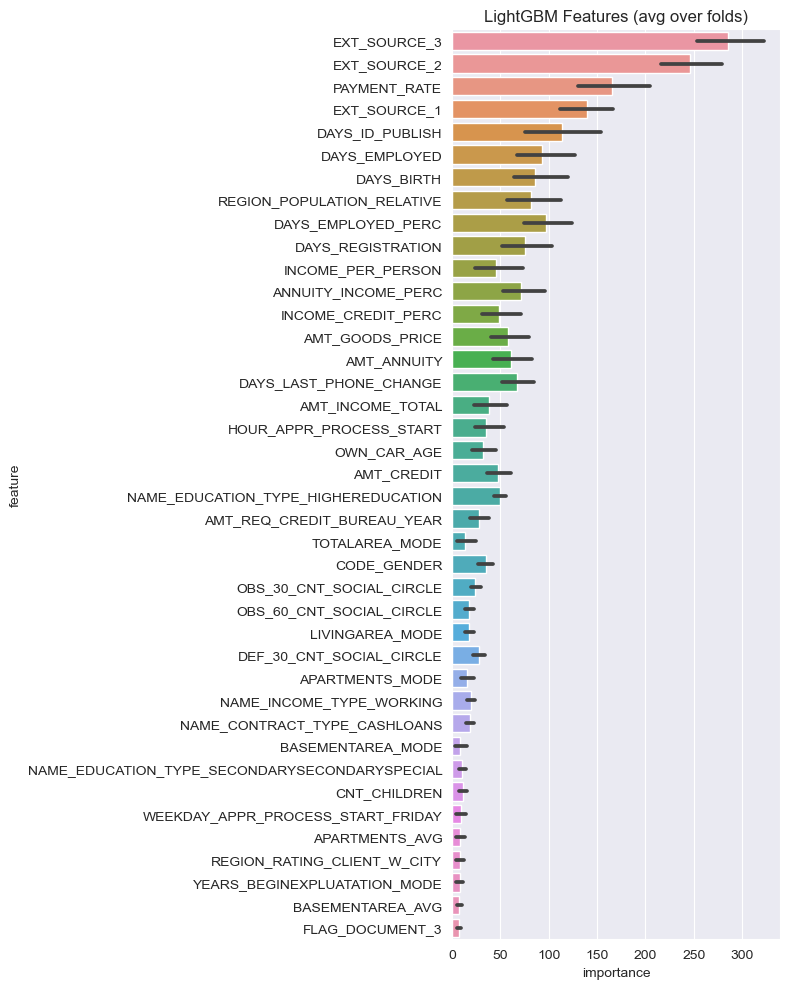

In [103]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
    nthread=4,
    n_estimators=500,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

    print(train_idx.shape, valid_idx.shape)

    # Train the LightGBM model with the custom evaluation metric
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric=credit_cost_function_search_best_threshold, verbose=200,
        early_stopping_rounds=200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

    clf.booster_.save_model('model.txt')

    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

display_importances(feature_importance_df)

In [31]:
# Utilisez le meilleur seuil pour faire des prédictions sur les données de test
#test_preds = (sub_preds >= best_threshold).astype(int)

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#test_df['TARGET'] = sub_preds
#test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)

Full AUC score 0.760635


In [32]:
# Faire le MLflow avant.
# en parallèle dashboard
# Comparaison avec AUC, et un random forest, voir xgboost ?
# Le tableau HTML d’analyse de data drift réalisé à partir d’evidently

# Test sur la partie API à minima voir sur autre fonction
# Ajouter des métriques afin de pouvoir comparer entre les modèles


In [33]:
train_x

NameError: name 'train_x' is not defined

In [34]:
train_y

NameError: name 'train_y' is not defined

In [35]:
# Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
display_importances(feature_importance_df)


C:\Users\PC1\AppData\Local\Temp\ipykernel_19036\959283263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


NameError: name 'submission_file_name' is not defined

In [36]:
top_100_features = feature_importance_df.nlargest(100, 'importance')

In [37]:
list_top_features = top_100_features['feature'].unique()

In [38]:
list_top_features

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'DAYS_ID_PUBLISH',
       'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
       'INCOME_CREDIT_PERC', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL',
       'HOUR_APPR_PROCESS_START', 'OWN_CAR_AGE', 'AMT_CREDIT'],
      dtype=object)

# Random forest classifier

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import StratifiedKFold

def evaluate_credit_risk_model(data, target, model):
    """
    Evaluate the model regarding credit risk using cross-validation.

    Parameters:
    - data: DataFrame, containing the feature columns (Age, Income, LoanAmount, CreditScore).
    - target: Series, the target variable indicating credit default (IsDefault).
    - model: A fitted machine learning model with `fit` method (e.g., LogisticRegression, RandomForestClassifier, etc.).

    Returns:
    A dictionary containing the following credit risk evaluation metrics:
    - "accuracy": Accuracy of the model.
    - "precision": Precision, also known as positive predictive value.
    - "recall": Recall, also known as sensitivity or true positive rate.
    - "f1_score": F1 score, a harmonic mean of precision and recall.
    - "roc_auc_score": Area Under the Receiver Operating Characteristic Curve (ROC AUC),
                        which measures the model's ability to discriminate between positive
                        and negative classes.
    - "average_precision_score": Area Under the Precision-Recall Curve (AUC-PR), which measures the model's ability to
                                 predict positive samples more accurately, especially in imbalanced datasets.
    - "confusion_matrix": A confusion matrix showing the number of true positives (TP),
                          false positives (FP), true negatives (TN), and false negatives (FN).
    """

    evaluation = {}

    # Perform cross-validation and get predicted probabilities
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, data, target, cv=cv, method='predict_proba')

    print(y_pred_proba)
    print(y_pred_proba.shape)

    # Convert predicted probabilities to predicted labels (0 or 1)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print(y_pred)
    print(y_pred.shape)

    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    evaluation["accuracy"] = accuracy

    # Calculate precision
    precision = precision_score(target, y_pred)
    evaluation["precision"] = precision

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(target, y_pred_proba[:, 1])
    evaluation["roc_auc_score"] = roc_auc

    # Confusion Matrix to add

    # Calculate your custom evaluation metric
    custom_metric_value = credit_cost_function_search_best_threshold(target, y_pred_proba[:, 1])
    evaluation["custom_metric_value"] = custom_metric_value

    return evaluation

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
list_top_features

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'DAYS_ID_PUBLISH',
       'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
       'INCOME_CREDIT_PERC', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL',
       'HOUR_APPR_PROCESS_START', 'OWN_CAR_AGE', 'AMT_CREDIT'],
      dtype=object)

In [42]:
nouvelle_ligne = 'TARGET'

In [43]:
# Créer un nouveau tableau avec une dimension supplémentaire
tableau_etendu = np.resize(list_top_features, list_top_features.size + 1)

# Ajouter la nouvelle entrée
tableau_etendu[tableau_etendu.size - 1] = nouvelle_ligne

In [44]:
type_objet = type(tableau_etendu)
print(type_objet)

<class 'numpy.ndarray'>


In [45]:
type_objet = type(list_top_features)
print(type_objet)

<class 'numpy.ndarray'>


In [46]:
tableau_etendu = np.array(tableau_etendu)

In [47]:
tableau_etendu.size

21

In [48]:
list_top_features.size

20

In [49]:
unique_values = np.unique(tableau_etendu)

In [50]:
unique_values

array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'ANNUITY_INCOME_PERC', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_EMPLOYED_PERC', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'HOUR_APPR_PROCESS_START', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'OWN_CAR_AGE', 'PAYMENT_RATE',
       'REGION_POPULATION_RELATIVE', 'TARGET'], dtype=object)

In [51]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,172551,NaN,1,0,0,0,135000.0,454500.0,29173.5,454500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,172556,NaN,0,1,1,1,180000.0,500490.0,52555.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,172562,NaN,1,0,0,0,202500.0,523152.0,37336.5,463500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,172570,NaN,0,0,0,1,382500.0,967500.0,31338.0,967500.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0


In [52]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

list_top_features

df_noNa = df[unique_values].dropna()

# Divide in training/validation and test data
train_df = df_noNa[df_noNa['TARGET'].notnull()]
test_df = df_noNa[df_noNa['TARGET'].notnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#del df
gc.collect()

Starting LightGBM. Train shape: (1245, 21), test shape: (1245, 21)


11746

In [53]:
df_noNa

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,ANNUITY_INCOME_PERC,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,HOUR_APPR_PROCESS_START,INCOME_CREDIT_PERC,INCOME_PER_PERSON,OWN_CAR_AGE,PAYMENT_RATE,REGION_POPULATION_RELATIVE,TARGET
6,41301.0,1560726.0,1395000.0,171000.0,0.241526,-13778,-3130.0,0.227174,-619,-1562.0,...,0.774761,0.724000,0.492060,16,0.109564,57000.0,17.0,0.026463,0.035792,0.0
15,20160.0,299772.0,247500.0,157500.0,0.128000,-8728,-1157.0,0.132562,-1368,-925.0,...,0.115634,0.346634,0.678568,6,0.525399,157500.0,17.0,0.067251,0.020713,0.0
21,37561.5,1132573.5,927000.0,202500.0,0.185489,-14815,-1652.0,0.111509,-2299,0.0,...,0.437709,0.233767,0.542445,9,0.178796,67500.0,14.0,0.033165,0.025164,0.0
28,57676.5,790830.0,675000.0,270000.0,0.213617,-9994,-1796.0,0.179708,-2661,-849.0,...,0.600396,0.685011,0.524496,11,0.341413,270000.0,1.0,0.072932,0.046220,0.0
51,34596.0,675000.0,675000.0,540000.0,0.064067,-18632,-6977.0,0.374463,-1937,-1285.0,...,0.311510,0.713355,0.309275,10,0.800000,180000.0,7.0,0.051253,0.026392,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,22599.0,284400.0,225000.0,135000.0,0.167400,-10534,-1424.0,0.135181,-3209,-1011.0,...,0.227929,0.697669,0.194068,15,0.474684,135000.0,7.0,0.079462,0.031329,0.0
9953,36459.0,755190.0,675000.0,270000.0,0.135033,-13940,-976.0,0.070014,-4100,0.0,...,0.195882,0.485240,0.070109,11,0.357526,90000.0,13.0,0.048278,0.020246,1.0
9991,29790.0,375408.0,297000.0,315000.0,0.094571,-12272,-2319.0,0.188967,-4705,-1838.0,...,0.431454,0.517014,0.443615,16,0.839087,78750.0,8.0,0.079354,0.008019,0.0
9992,42417.0,781920.0,675000.0,180000.0,0.235650,-18883,-8268.0,0.437854,-2434,-3084.0,...,0.777809,0.676337,0.488455,18,0.230203,90000.0,11.0,0.054247,0.035792,0.0


In [54]:
# Créer une instance du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(train_df[list_top_features], test_df['TARGET'])

RandomForestClassifier(random_state=42)

## Evaluation

In [55]:
evaluate_credit_risk_model(train_df[list_top_features], test_df['TARGET'],rf_model)

[[0.94 0.06]
 [0.79 0.21]
 [0.9  0.1 ]
 ...
 [0.99 0.01]
 [0.97 0.03]
 [0.98 0.02]]
(1245, 2)
[0 0 0 ... 0 0 0]
(1245,)
Best cost : 74200
Best Threshold : 0.05
Best cost : 66700
Best Threshold : 0.1
Custom Credit Score: 66700


{'accuracy': 0.9293172690763052,
 'precision': 0.0,
 'roc_auc_score': 0.7230758541282035,
 'custom_metric_value': ('credit_cost_function', 66700, None)}

In [56]:
# Récupérer si moins de 5% de valeurs manquantes et sinon delete des colonnes.

In [57]:
test_df['TARGET'].shape

(1245,)

In [68]:
train_df.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,ANNUITY_INCOME_PERC,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,HOUR_APPR_PROCESS_START,INCOME_CREDIT_PERC,INCOME_PER_PERSON,OWN_CAR_AGE,PAYMENT_RATE,REGION_POPULATION_RELATIVE,TARGET
count,1245.000000,1.245000e+03,1.245000e+03,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,...,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000
mean,31068.213253,6.771325e+05,6.134663e+05,2.079348e+05,0.169437,-14034.163052,-2204.634538,0.154082,-3017.872289,-1105.334137,...,0.475322,0.536851,0.494004,12.205622,0.436705,1.031689e+05,11.568675,0.053912,0.021483,0.069880
std,16113.923382,4.356808e+05,4.025577e+05,1.178530e+05,0.091908,3226.390961,1990.923142,0.125266,1492.046300,865.683903,...,0.204500,0.173871,0.196813,3.301973,0.380960,8.839059e+04,11.766463,0.022481,0.014065,0.255046
min,4311.000000,5.212800e+04,4.500000e+04,2.700000e+04,0.012500,-23437.000000,-14387.000000,0.001196,-6228.000000,-3645.000000,...,0.024417,0.001340,0.000527,2.000000,0.051236,9.000000e+03,0.000000,0.025280,0.001276,0.000000
25%,19516.500000,3.128400e+05,2.700000e+05,1.350000e+05,0.106250,-16131.000000,-3044.000000,0.058426,-4302.000000,-1723.000000,...,0.305952,0.440952,0.345785,10.000000,0.208333,5.250000e+04,4.000000,0.037374,0.010006,0.000000
50%,28863.000000,5.850000e+05,4.950000e+05,1.800000e+05,0.152090,-13598.000000,-1590.000000,0.119304,-3228.000000,-925.000000,...,0.475762,0.579909,0.515495,12.000000,0.322713,7.875000e+04,9.000000,0.050000,0.019101,0.000000
75%,39856.500000,9.090000e+05,9.000000e+05,2.475000e+05,0.213286,-11610.000000,-747.000000,0.217791,-1801.000000,-384.000000,...,0.641474,0.668476,0.647977,15.000000,0.530035,1.237500e+05,15.000000,0.064066,0.028663,0.000000
max,135936.000000,2.925000e+06,2.925000e+06,1.035000e+06,0.818433,-7806.000000,-22.000000,0.670691,-10.000000,0.000000,...,0.889079,0.803422,0.885488,22.000000,4.000000,1.035000e+06,65.000000,0.120377,0.072508,1.000000


In [67]:
train_y

6       0.0
15      0.0
21      0.0
28      0.0
51      0.0
       ... 
9949    0.0
9953    1.0
9991    0.0
9992    0.0
9995    0.0
Name: TARGET, Length: 1120, dtype: float64

# XGBoost

(1120,) (125,)
Best cost : 104200
Best Threshold : 0.05
Best cost : 35500
Best Threshold : 0.5
Custom Credit Score: 35500
Best cost : 11600
Best Threshold : 0.05
Best cost : 7700
Best Threshold : 0.5
Custom Credit Score: 7700
[0]	validation_0-logloss:0.67617	validation_0-credit_cost_function_search_best_threshold_v2:35500.00000	validation_1-logloss:0.67784	validation_1-credit_cost_function_search_best_threshold_v2:7700.00000
Best cost : 104200
Best Threshold : 0.05
Best cost : 44100
Best Threshold : 0.5
Custom Credit Score: 44100
Best cost : 11600
Best Threshold : 0.05
Best cost : 9300
Best Threshold : 0.5
Best cost : 9000
Best Threshold : 0.55
Custom Credit Score: 9000
Best cost : 104200
Best Threshold : 0.05
Best cost : 45200
Best Threshold : 0.5
Custom Credit Score: 45200
Best cost : 11600
Best Threshold : 0.05
Best cost : 9300
Best Threshold : 0.5
Best cost : 9000
Best Threshold : 0.55
Custom Credit Score: 9000
Best cost : 104200
Best Threshold : 0.05
Best cost : 42300
Best Thresho

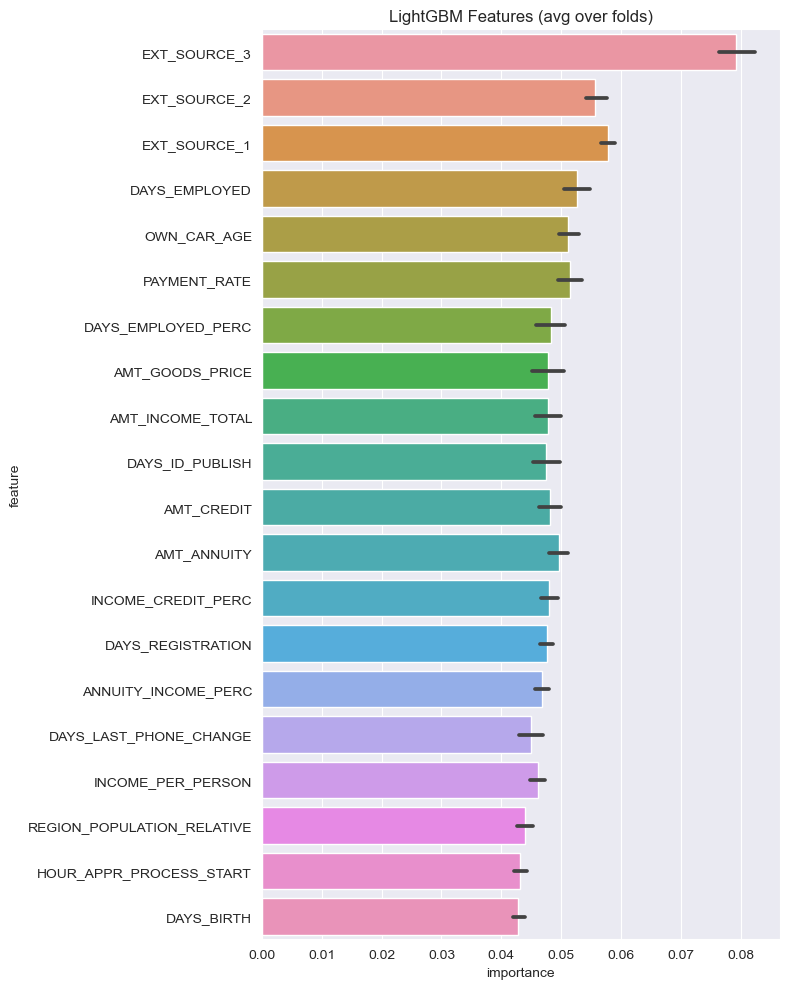

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

#feats = [...]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[list_top_features], train_df['TARGET'])):
    train_x, train_y = train_df[list_top_features].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[list_top_features].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    # XGBoost parameters
    clf = XGBClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=8,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        reg_lambda=0.005,
        gamma=0.1,
        objective='binary:logistic',
        nthread=4,
        seed=42,
        missing=np.nan,
        eval_metric=credit_cost_function_search_best_threshold_v2,
        early_stopping_rounds=200
    )

    print(train_idx.shape, valid_idx.shape)

    # Entraîner le modèle XGBoost
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], verbose=200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[list_top_features])[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list_top_features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

average_auc = np.mean([roc_auc_score(train_df['TARGET'], oof_preds)])

print(f'Average AUC: {average_auc:.6f}')

# Afficher les meilleures métriques
best_metrics = {
    'Fold': [],
    'AUC': []
}

for n_fold, (_, valid_idx) in enumerate(folds.split(train_df[list_top_features], train_df['TARGET'])):
    best_metrics['Fold'].append(n_fold + 1)
    best_metrics['AUC'].append(roc_auc_score(train_df['TARGET'].iloc[valid_idx], oof_preds[valid_idx]))

best_metrics_df = pd.DataFrame(best_metrics)
print(best_metrics_df)

# Afficher l'importance des fonctionnalités
display_importances(feature_importance_df)